In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

from heapq import heappush, heappop
import os
import matplotlib.cm as cm
from tqdm import tqdm
import polars as pl

import geopandas as gpd

from shapely.geometry import Point, Polygon
from shapely import wkt

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from pyproj import Transformer

from bayesian_statistics.utils_2 import *
import japanize_matplotlib

from keplergl import KeplerGl

from typing import Tuple

In [2]:
data_dir = "/home/ohta/dev/bayesian_statistics/data"

obsedian_path = "11_gdf_obsedian.csv"
sites_path = "12_gdf_sites_with_ratio.csv"
elevation_path = "12_gdf_elevation_with_ratio.csv"

df_obsedian = pl.read_csv(os.path.join(data_dir, obsedian_path))
df_sites = pl.read_csv(os.path.join(data_dir, sites_path))
df_elevation = pl.read_csv(os.path.join(data_dir, elevation_path))

time_period_name = {
    0: "早期・早々期",
    1: "前期",
    2: "中期",
    3: "後期",
    4: "晩期"
}


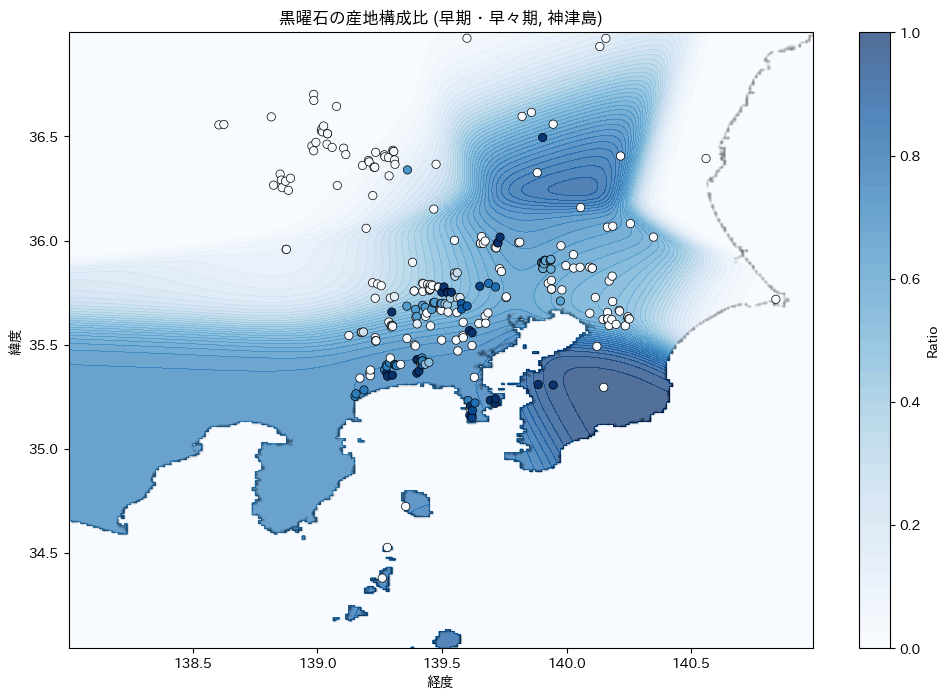

In [3]:
def plot_contour(df, x_col='x', y_col='y', value_col='cost_kouzu', figsize=(12, 8), plot_probability=False, n_levels=30):

    # まず海陸判定のマスクを作成
    mask = (
        df
        .with_columns(
            (~pl.col('is_sea')).alias("is_not_sea")
        )
        .pivot(
            values='is_not_sea',
            on=x_col,
            index=y_col
        )
    )

    # 値のピボットテーブルを作成
    grid_data = (
        df
        .pivot(
            values=value_col,
            on=x_col,
            index=y_col
        )
    )

    # マスクを適用（y_col列は保持）
    grid_data = grid_data.with_columns(
        [
            pl.col(col) * mask.get_column(col)
            for col in grid_data.columns
            if col != y_col
        ]
    )
    
    # メッシュグリッドの作成
    x_mesh = np.array(grid_data.columns[1:], dtype=float)
    y_mesh = np.array(grid_data.to_numpy()[:, 0], dtype=float)
    values_mesh = grid_data.to_numpy()[:, 1:]
    
    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_probability:
        # 確率表示モード（0-1の範囲）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh,
            levels=np.linspace(0, 1, n_levels + 1),
            cmap='Blues',
            alpha=0.7,
            vmin=0,
            vmax=1
        )
    else:
        # 通常モード（データをそのまま使用）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh, 
            levels=n_levels, 
            cmap='Blues',
            alpha=0.7
        )
    
    # カラーバーの追加
    if plot_probability:
        # カラーバー（0-1の範囲に固定）
        plt.colorbar(contour, ax=ax, label='Ratio', ticks=np.linspace(0, 1, 6))
    else:
        plt.colorbar(contour, ax=ax)
    
    # ラベルの設定
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')
    
    return fig, ax

# 通常プロット（データそのまま）

period = 0
origin = "神津島"

fig, ax = plot_contour(df_elevation, value_col=f"ratio_{period}_{origin}", plot_probability=True, n_levels=40)

boundary_df = df_elevation.filter(pl.col("is_sea") == 0, pl.col("average_elevation").is_null())

ax.scatter(
    boundary_df["x"], 
    boundary_df["y"], 
    c="black", 
    s=0.001
)

ax.scatter(
    df_sites["経度"], 
    df_sites["緯度"], 
    c=df_sites[f"比率_{period}_{origin}"], 
    cmap="Blues", 
    edgecolors="black", 
    linewidths=0.5,
    vmin=0,
    vmax=1 
)

ax.set_title(f"黒曜石の産地構成比 ({time_period_name[period]}, {origin})")

plt.show()